In [2]:
import pandas as pd

df = pd.read_csv('../../survey_processing/processed_data/dhs_processed.csv')
df

,CENTROID_ID,SURVEY_NAME,COUNTRY,YEAR,LATNUM,LONGNUM,cluster,health_vac_moddep,health_con_moddep,health_ari_moddep,...,hv201_71,hv009,hv105,hv216,v005,hv205_14,v312_17,v312_2,hv201_12,hv205_31
0,UG201600000001,Uganda_DHS_2016,Uganda,2016,0.320188,32.568206,1.0,0.000000,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000
1,UG201600000002,Uganda_DHS_2016,Uganda,2016,0.340653,32.593627,2.0,0.032258,0.0,0.0,...,0.0,0.148859,0.299020,0.065217,0.119688,0.0,0.0,0.0,0.0,0.166667
2,UG201600000003,Uganda_DHS_2016,Uganda,2016,0.313103,32.566556,3.0,0.052632,0.0,0.0,...,0.0,0.116183,0.058824,0.065217,0.085795,0.0,0.0,0.0,0.0,0.000000
3,UG201600000004,Uganda_DHS_2016,Uganda,2016,0.353368,32.558144,4.0,0.108108,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000
4,UG201600000005,Uganda_DHS_2016,Uganda,2016,0.367388,32.594357,5.0,0.034483,0.0,0.0,...,0.0,0.148133,0.435294,0.065217,0.146261,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24209,ET201900000301,Ethiopia_DHS_2019,Ethiopia,2019,9.614227,41.997375,301.0,0.054054,0.0,0.0,...,0.0,0.247087,0.535858,0.068791,0.005866,0.0,0.0,0.0,0.0,0.986301
24210,ET201900000302,Ethiopia_DHS_2019,Ethiopia,2019,9.554591,41.863785,302.0,0.098361,0.0,0.0,...,0.0,0.203657,0.295486,0.078868,0.008044,0.0,0.0,0.0,0.0,0.093023
24211,ET201900000303,Ethiopia_DHS_2019,Ethiopia,2019,9.524405,41.834015,303.0,0.042553,0.0,0.0,...,0.0,0.249230,0.496521,0.078541,0.009587,0.0,0.0,0.0,0.0,0.946237
24212,ET201900000304,Ethiopia_DHS_2019,Ethiopia,2019,9.514266,41.770584,304.0,0.029126,0.0,0.0,...,0.0,0.272525,0.478391,0.071872,0.005691,0.0,0.0,0.0,0.0,0.540816


In [3]:
import geopandas as gpd
from shapely.geometry import Point
# Convert the DataFrame into a GeoDataFrame
def append_geo(df):
    gdf_points = gpd.GeoDataFrame(
        df, 
        geometry=gpd.points_from_xy(df['LONGNUM'], df['LATNUM']),
        crs="EPSG:4326"
    )

    # Load the admin 2 boundaries GeoDataFrame
    # Ensure that the file includes polygons for admin 2 subdivisions in Africa
    admin2_gdf = gpd.read_file('afr_adm2/afr_g2014_2013_2.shp')

    # Project both GeoDataFrames to a common CRS if necessary
    if admin2_gdf.crs != gdf_points.crs:
        admin2_gdf = admin2_gdf.to_crs(gdf_points.crs)

    # Perform the spatial join
    # 'how="left"' means all points will remain, gaining admin 2 data if they fall within a polygon
    joined_gdf = gpd.sjoin(gdf_points, admin2_gdf, how="left", predicate="within")

    # Suppose the admin 2 name column in the polygons is named "admin2_name"
    return joined_gdf

/rds/project/rds-KNoCjrg2atA/cs-yang3/envs/sat/lib/python3.10/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_183444/17319105.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if yo

In [7]:
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import warnings
warnings.filterwarnings('ignore')

def get_test_df(fold):
    folder = f'../dino/results/split_spatialS_{fold}_[4, 3, 2]/'
    # Load training and test data
    X_train = pd.read_csv(folder+'X_train.csv')
    y_train = pd.read_csv(folder+'y_train.csv').squeeze()  # ensure it's a Series
    X_test = pd.read_csv(folder+'X_test.csv')
    y_test = pd.read_csv(folder+'y_test.csv').squeeze()
    test_csv = f'../../survey_processing/processed_data/test_fold_{fold}.csv'
    test_df = pd.read_csv(test_csv)
    import os
    available_imagery = []
    imagery_path = '/home/cs-yang3/rds/rds-t2-cs177-KNoCjrg2atA/wp3/data/satellite_imagery/esa_10'
    for d in os.listdir(imagery_path):
        if d[-2] == 'S':
            for f in os.listdir(os.path.join(imagery_path, d)):
                available_imagery.append(os.path.join(imagery_path, d, f))

    def is_available(centroid_id):
        for centroid in available_imagery:
            if centroid_id in centroid:
                return True
        return False
    test_df = test_df[test_df['CENTROID_ID'].apply(is_available)]

    test_df.dropna(subset=['deprived_sev'], inplace=True)
    y_test = test_df['deprived_sev']
    # Define a pipeline with scaling and RidgeCV
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0, 100, 1000], cv=5))
    ])

    # Fit the pipeline on training data
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test).clip(0, 1)

    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)
    print("Test MAE:", mae)
    
    test_df
    test_df['y_pred'] = y_pred

    return test_df

# get all 5 fold and stack them
test_df = pd.concat([get_test_df(fold) for fold in range(1, 6)])

Test MAE: 0.1559883912263654
Test MAE: 0.16162945019234545
Test MAE: 0.16834470150281267
Test MAE: 0.168547881884699
Test MAE: 0.16077005330382718


In [8]:
test_df['error'] = (test_df['deprived_sev'] - test_df['y_pred']).abs()
test_df['are'] = (test_df['error'] / test_df['deprived_sev'])

In [9]:
test_with_geo = append_geo(test_df)

In [10]:
# filter dataframe with REGION == middle or eastern africa
# test_with_geo = test_with_geo[test_with_geo['REGION'].isin(['Middle Africa', 'Eastern Africa'])]


In [11]:
# aggregated by country + admin2 and average by error
grouped_df = test_with_geo.groupby(['COUNTRY', 'ADM2_NAME'])[['deprived_sev','y_pred','error','are','LATNUM','LONGNUM']].mean().reset_index()

In [12]:
grouped_df['admin2_error'] = (grouped_df['deprived_sev'] - grouped_df['y_pred']).abs()

In [13]:
grouped_df.admin2_error.mean()

0.10032726009567933

In [14]:
grouped_df.head()

,COUNTRY,ADM2_NAME,deprived_sev,y_pred,error,are,LATNUM,LONGNUM,admin2_error
0,Angola,Alto Cauale,0.979592,0.963947,0.015645,0.015971,-7.487095,16.225420,0.015645
1,Angola,Alto Zambeze,0.928870,0.845761,0.099198,0.121564,-11.772236,23.197412,0.083108
2,Angola,Ambaca,0.760634,0.734403,0.137660,0.305120,-8.266549,15.527677,0.026231
3,Angola,Amboim,0.771490,0.656733,0.275692,0.392233,-10.852732,14.415432,0.114757
4,Angola,Ambriz,0.595293,0.682994,0.087702,0.165075,-7.857252,13.418285,0.087702


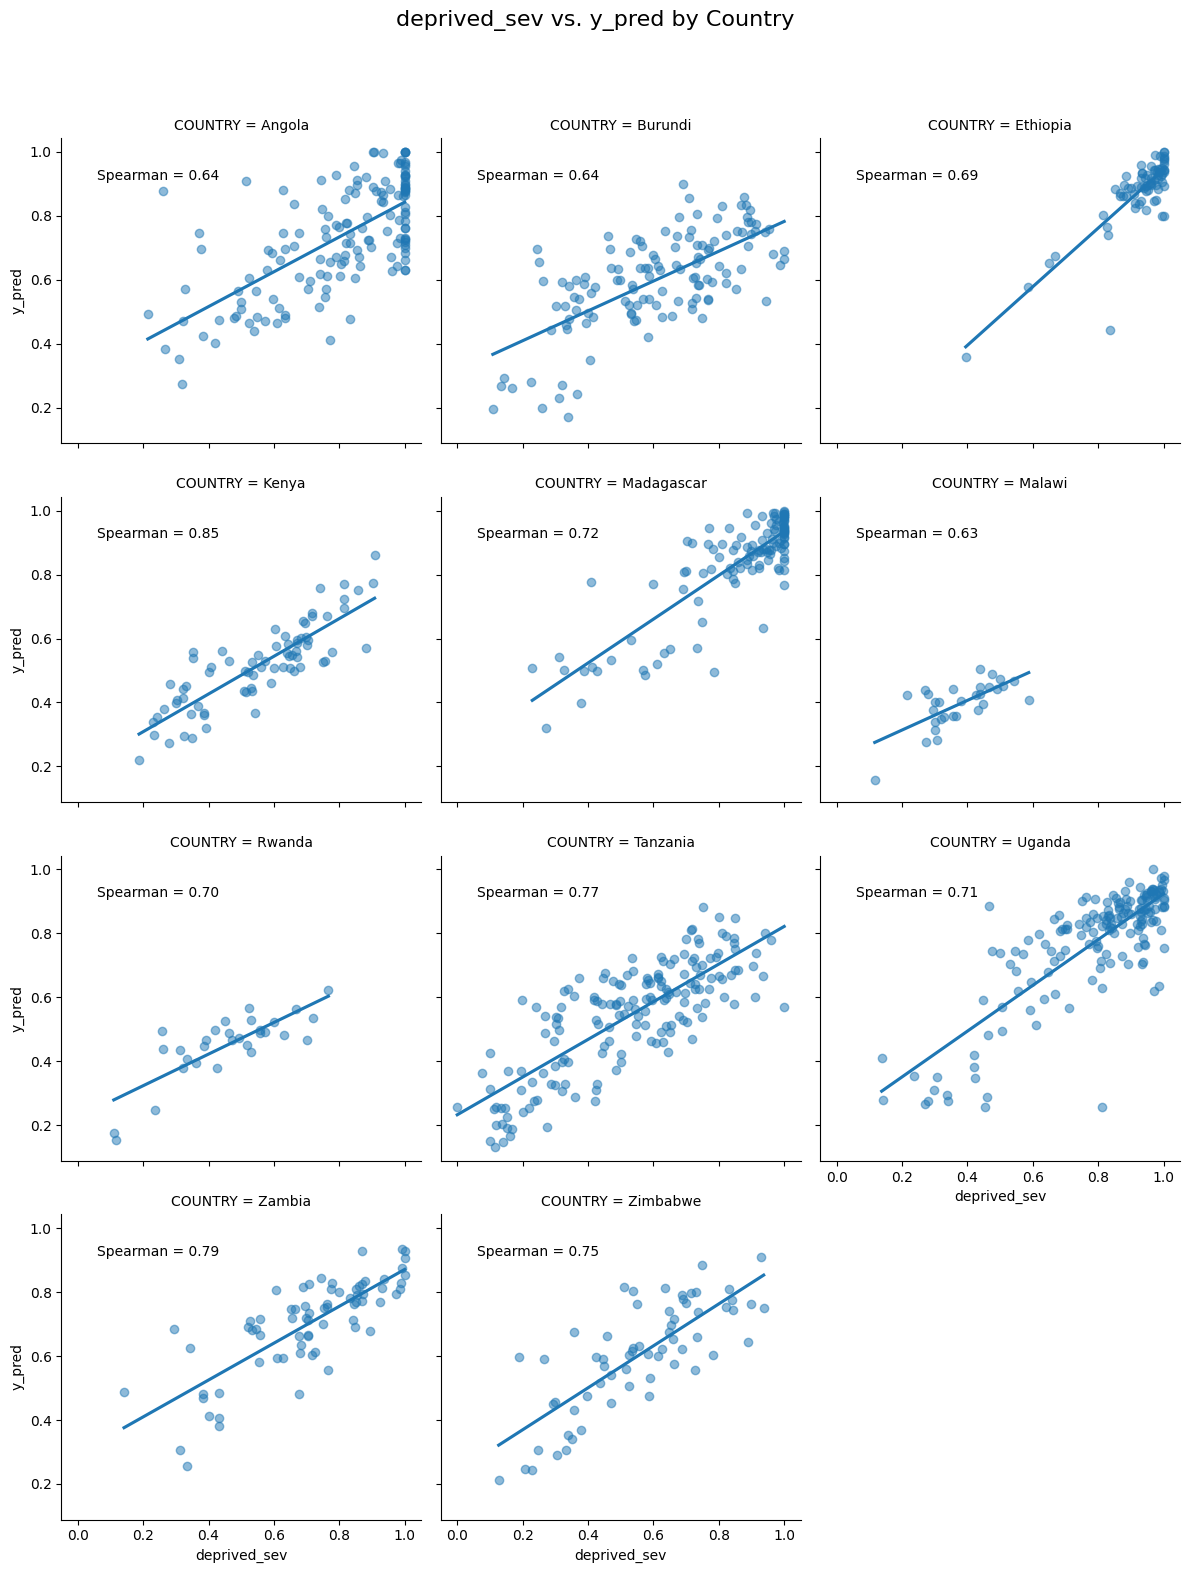

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import spearmanr

# Assume your DataFrame is called df
# df columns: COUNTRY, ADM2_NAME, deprived_sev, y_pred

# Create the facet grid scatter plots with regression lines
g = sns.lmplot(data=grouped_df, x='deprived_sev', y='y_pred', col='COUNTRY', 
               col_wrap=3, height=4, aspect=1, scatter_kws={'alpha':0.5}, ci=None)

# Compute and annotate R² for each subplot
for ax, country in zip(g.axes.flat, grouped_df['COUNTRY'].unique()):
    country_data = grouped_df[grouped_df['COUNTRY'] == country]
    rho, p_value = spearmanr(country_data['deprived_sev'], country_data['y_pred'])
    # Position the text inside the subplot
    ax.text(0.1, 0.9, f'Spearman = {rho:.2f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')

plt.subplots_adjust(top=0.9)
g.fig.suptitle("deprived_sev vs. y_pred by Country", fontsize=16)  # Add a global title if desired
plt.show()

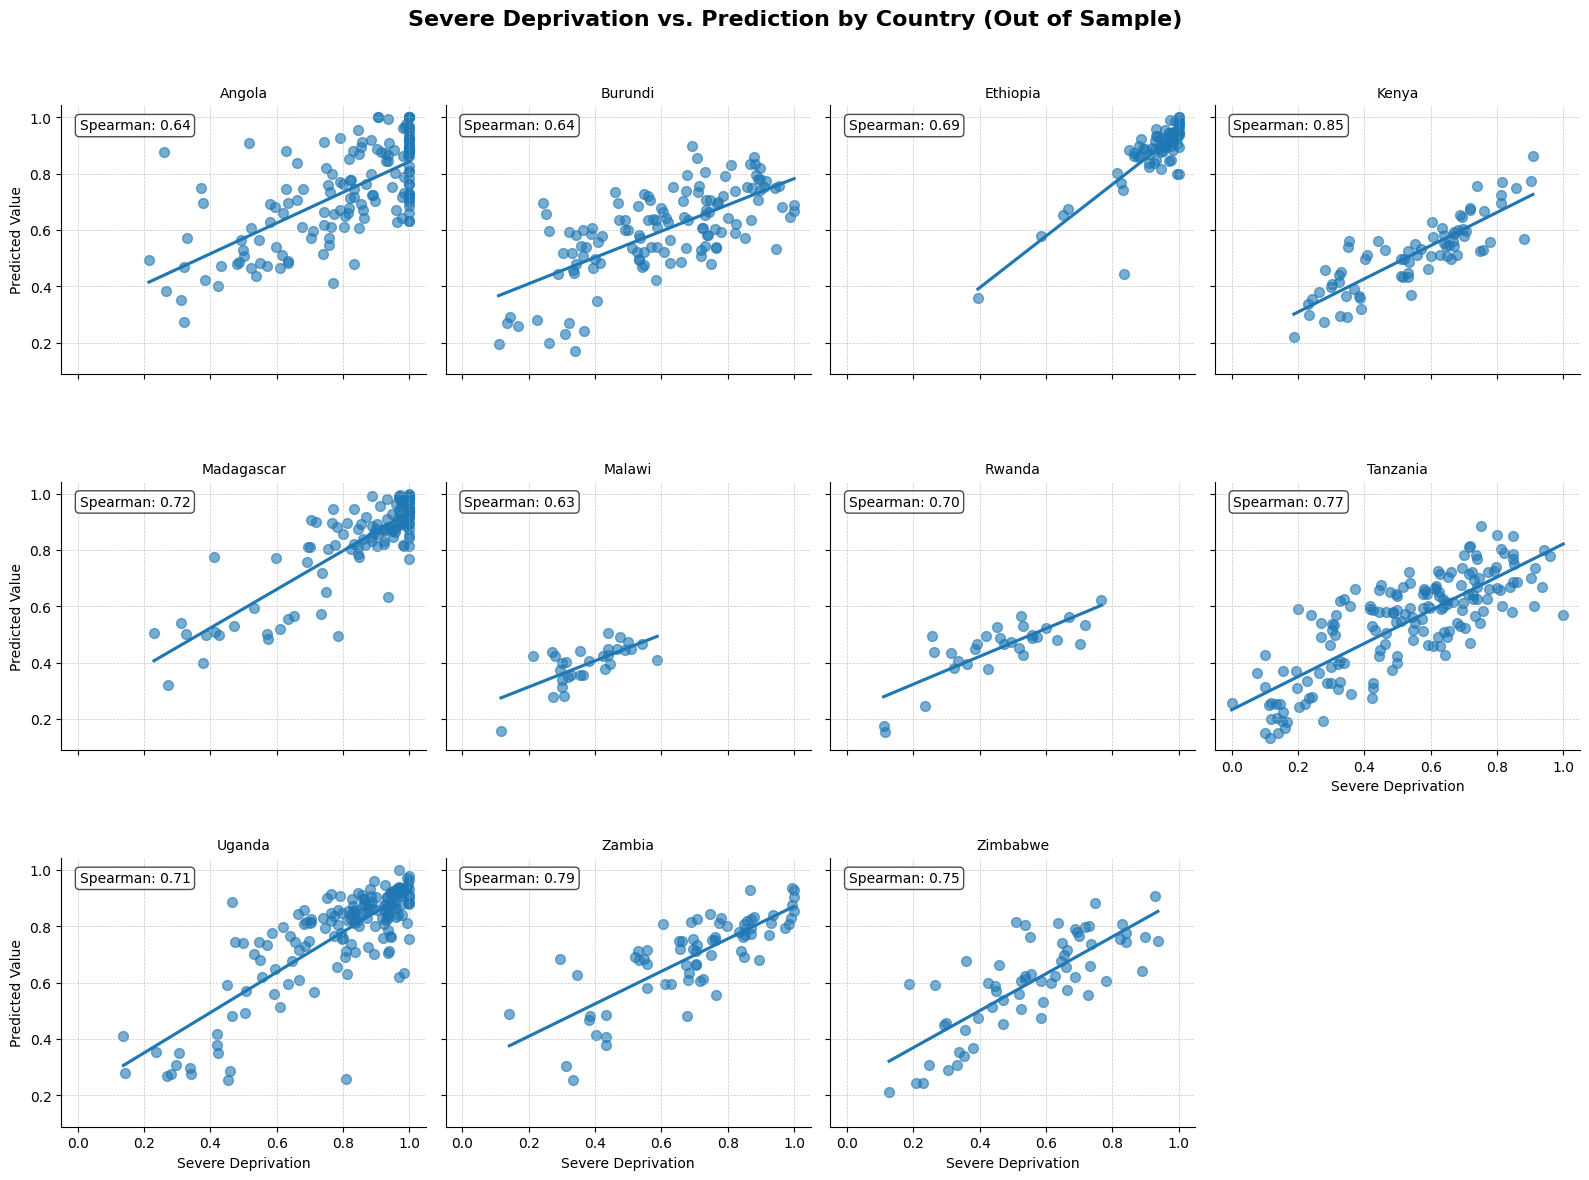

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Create the facet grid scatter plots with regression lines
g = sns.lmplot(
    data=grouped_df,
    x='deprived_sev', 
    y='y_pred', 
    col='COUNTRY', 
    col_wrap=4, 
    height=4, 
    aspect=1, 
    scatter_kws={'alpha': 0.6, 's': 50},  # Increase marker size for better visibility
    ci=None,
    palette="Set2"  # Use a visually appealing palette
)
g.set_titles("{col_name}")  # This sets the title template to just the column name (country)
# Compute and annotate Spearman R for each subplot
for ax, country in zip(g.axes.flat, grouped_df['COUNTRY'].unique()):
    country_data = grouped_df[grouped_df['COUNTRY'] == country]
    rho, p_value = spearmanr(country_data['deprived_sev'], country_data['y_pred'])
    ax.text(
        0.05, 0.95, 
        f'Spearman: {rho:.2f}', 
        transform=ax.transAxes, 
        fontsize=10, 
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)  # Add a background box for clarity
    )

# Improve layout and add a global title
plt.subplots_adjust(top=0.9, hspace=0.4)  # Adjust subplot spacing
g.fig.suptitle("Severe Deprivation vs. Prediction by Country (Out of Sample)", fontsize=16, fontweight='bold')

# Customize axis labels
g.set_axis_labels("Severe Deprivation", "Predicted Value")

# Add grid lines for clarity
for ax in g.axes.flat:
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()

In [17]:
points_gdf = gpd.GeoDataFrame(
    grouped_df,
    geometry=gpd.points_from_xy(grouped_df['LONGNUM'], grouped_df['LATNUM']),
    crs="EPSG:4326"
)
admin2_gdf  = gpd.read_file('afr_adm2/afr_g2014_2013_2.shp')
# 3. Spatial join to find which admin 2 each point belongs to
joined_gdf = gpd.sjoin(points_gdf, admin2_gdf, how="left", predicate="within")

# Assume admin 2 name column in the shapefile is 'ADM2_NAME'
# Now joined_gdf contains 'ADM2_NAME' for each point along with 'value'.

# 4. Aggregate values by admin 2 region if multiple points belong to the same region
joined_gdf['ADM2_NAME'] = joined_gdf['ADM2_NAME_left']

# Merge aggregated data back into the admin2_gdf
choropleth_gdf = admin2_gdf.merge(joined_gdf, on='ADM2_CODE', how='right')
# choropleth_gdf = joined_gdf


In [18]:
# remove nan from choropleth_gdf
choropleth_gdf = choropleth_gdf.dropna(subset=['are'])
# remove inf from choropleth_gdf
choropleth_gdf = choropleth_gdf[~choropleth_gdf['are'].isin([float('inf')])]

<Axes: >

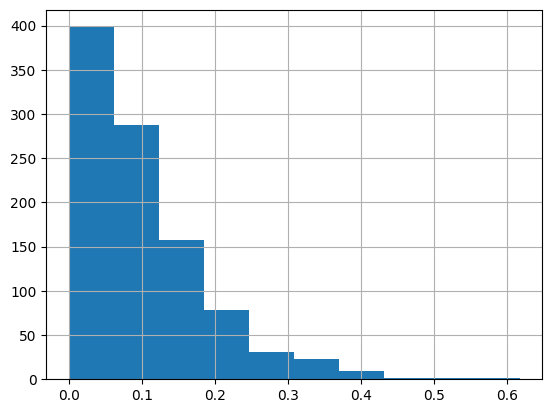

: 

In [21]:
choropleth_gdf.admin2_error.hist()

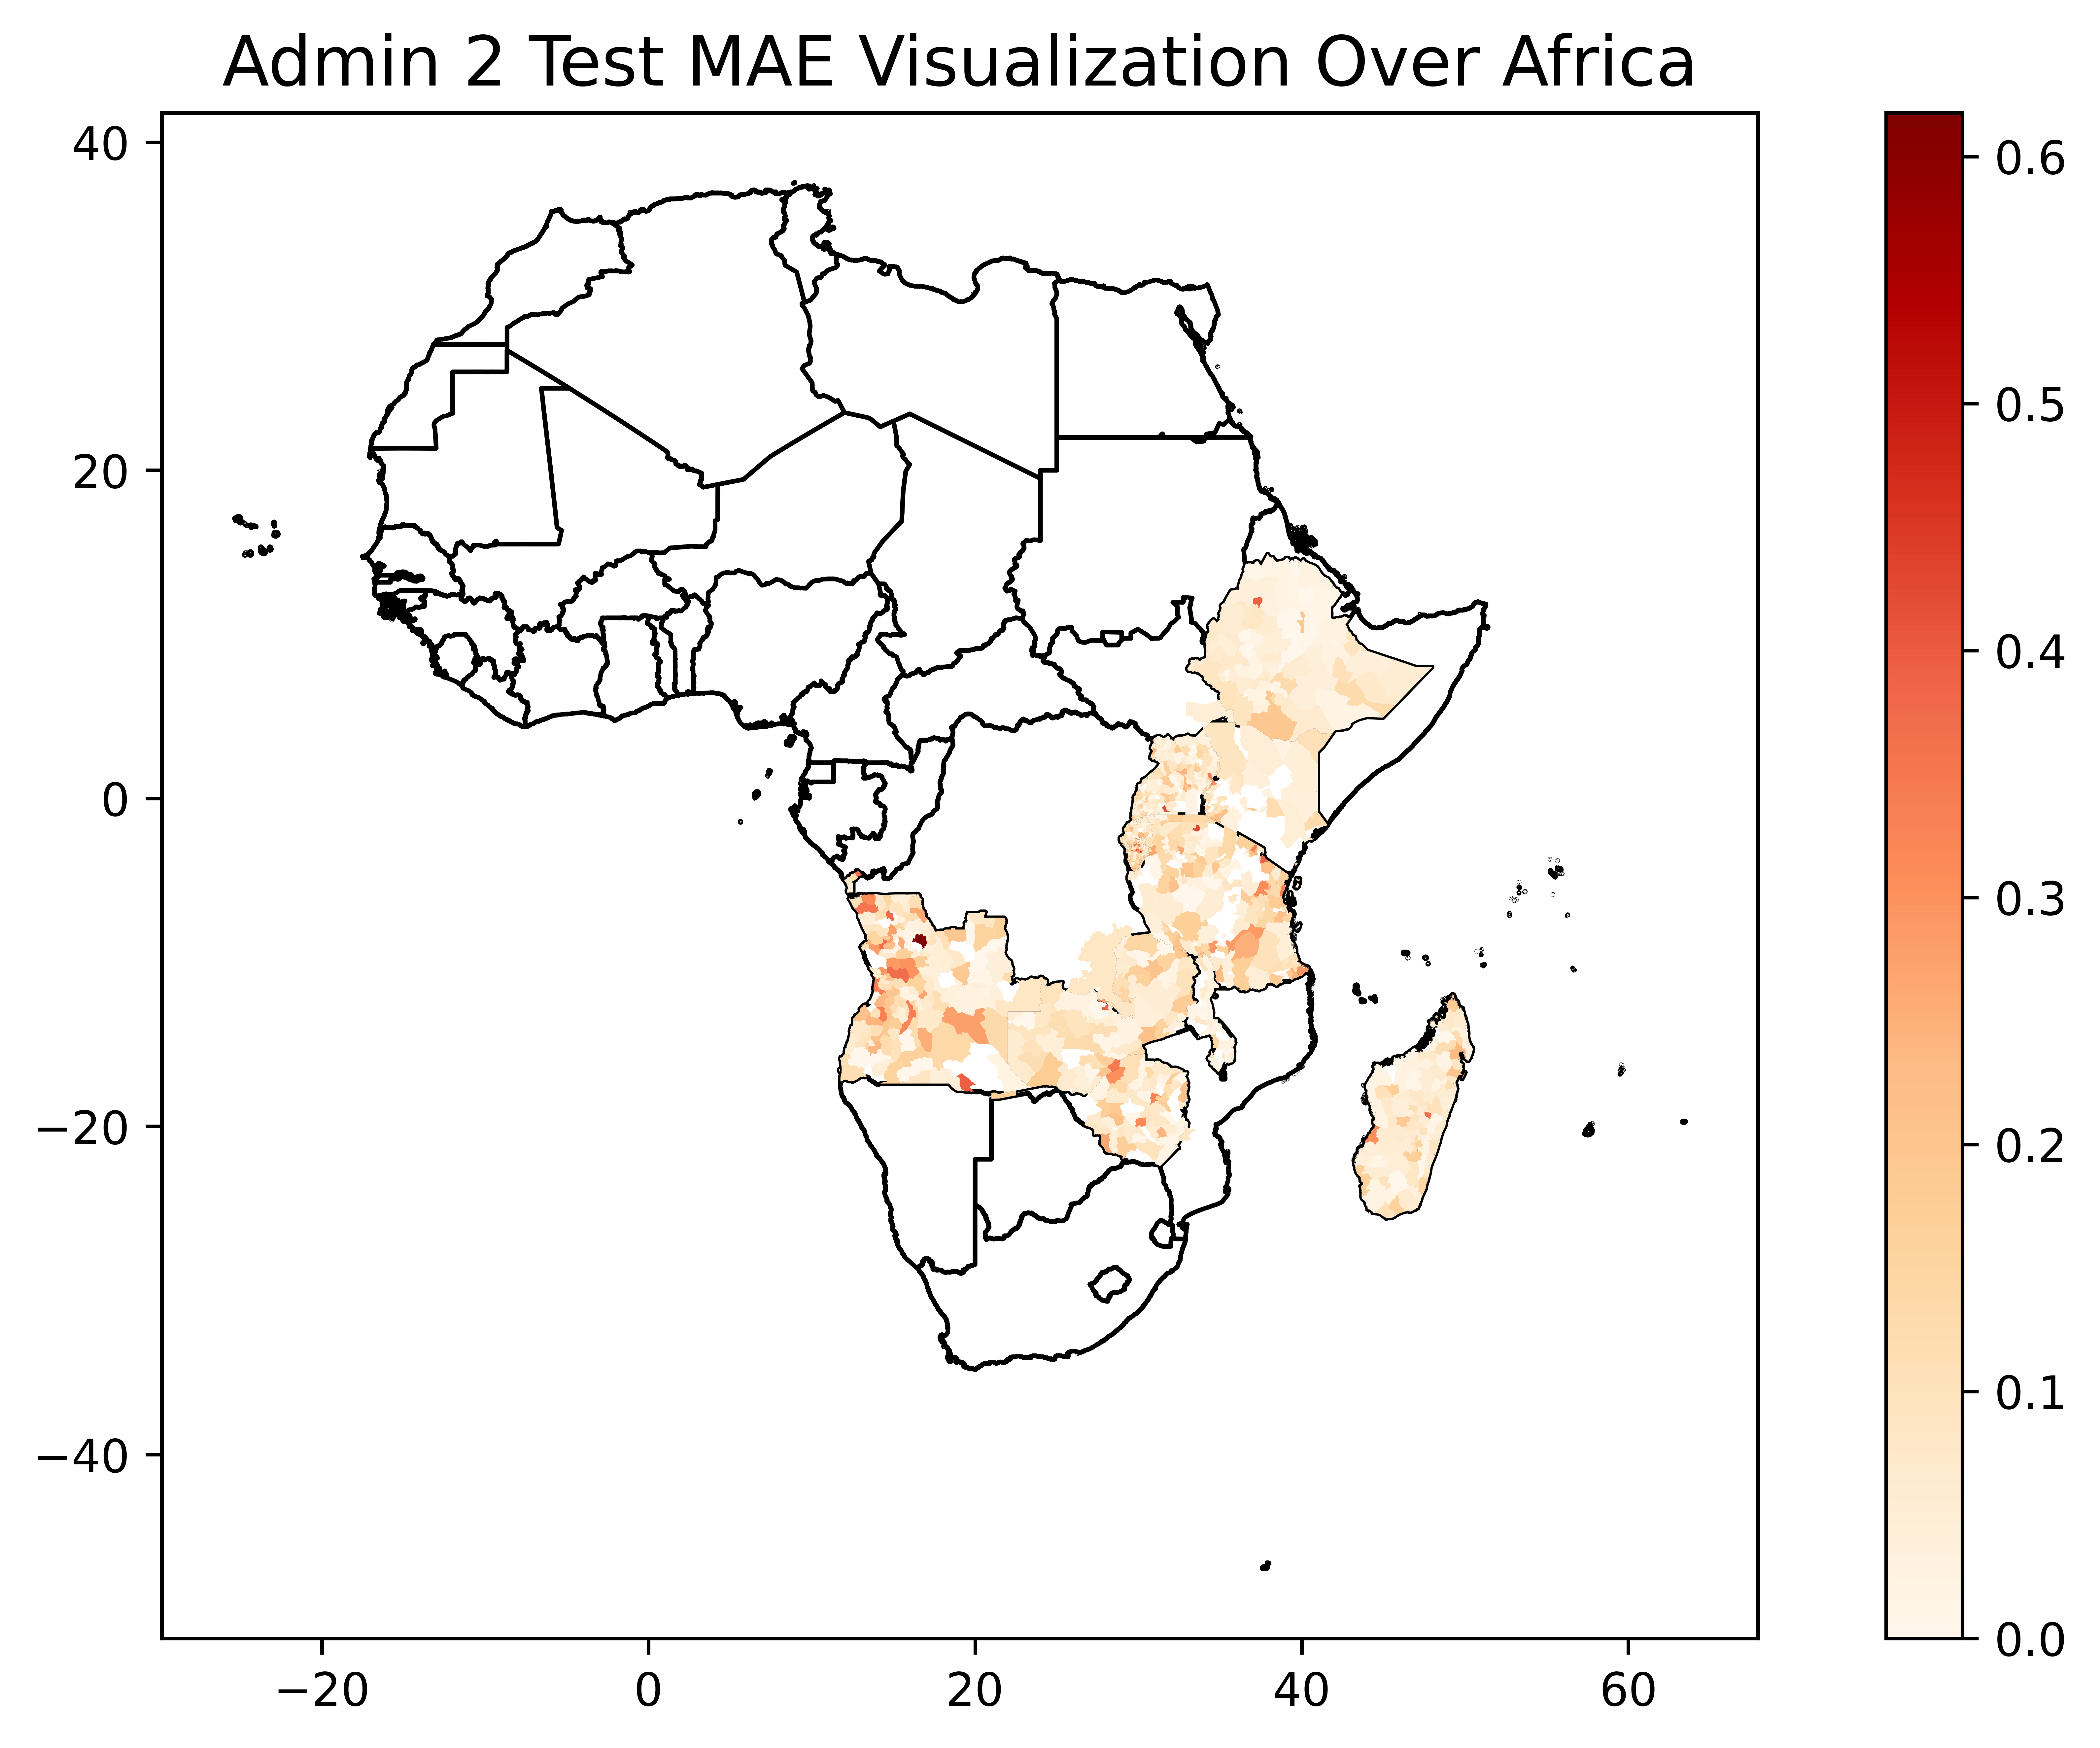

In [20]:
choropleth_gdf = gpd.GeoDataFrame(choropleth_gdf, geometry='geometry_x')


# Optionally set a title
import geopandas as gpd
import matplotlib.pyplot as plt

# Load Africa boundary shapefile (this could be a countries-level shapefile)
africa_gdf = gpd.read_file('afr_adm0/afr_g2014_2013_0.shp')

# Ensure all GeoDataFrames are in the same CRS
if africa_gdf.crs != choropleth_gdf.crs:
    africa_gdf = africa_gdf.to_crs(choropleth_gdf.crs)

fig, ax = plt.subplots(figsize=(10, 6), dpi=1000)

# Plot the Africa boundary as a base layer
africa_gdf.plot(ax=ax, color='white', edgecolor='black')

# Plot the admin 2 level choropleth on top # adjust line width
choropleth_gdf.plot(column='admin2_error', cmap='OrRd', legend=True, ax=ax, linewidth=0.5)

ax.set_title("Admin 2 Test MAE Visualization Over Africa", fontsize=15)
plt.show()

In [ ]:
choropleth_gdf.REGION_x.unique()

array(['Middle Africa', 'Southern Africa', 'Eastern Africa', None, nan],
      dtype=object)